In [1]:
import os
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Input, Activation, Add, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import load_model

Using TensorFlow backend.


In [2]:
path = "/root/userspace/kadai/0121/"

In [3]:
import numpy as np
import pandas as pd

def load_dataset():
    # 学習データ
    X_train = np.load(path+'data/X_train.npy')
    y_train = np.load(path+'data/y_train.npy')
    # テストデータ
    X_test = np.load(path+'data/X_test.npy')
    
    X_train = X_train / 255.
    X_test = X_test / 255.
    y_train = np.eye(4)[y_train]
    
    return (X_train, X_test, y_train)

X_train, X_test, y_train = load_dataset()

In [4]:
#画像サイズの確認
print(X_train.shape)
print(y_train.shape)

(450, 299, 299, 3)
(450, 4)


In [5]:
#for i in range(5):
#    label = y_train[i]
#    img = X_train[i]
#    print("label=", label)
#    img = img.reshape(299,299,3)
#    img = np.uint8(img*255)
#    plt.imshow(img)
#    plt.show()

In [6]:
#データ生成器
datagen = ImageDataGenerator(
    #samplewise_center=False,
    #samplewise_std_normalization=False,
    #zca_whitening=True,
    width_shift_range=0.1,  # 3.1.1 左右にずらす
    height_shift_range=0.1,  # 3.1.2 上下にずらす
    #horizontal_flip=True,  # 3.1.3 左右反転
    zoom_range=[0.8, 1.2],
    rotation_range=5,
    brightness_range=[0.8, 1.2],
)

In [7]:
def get_model_vgg_like():    
    inputs = Input(shape=(299,299,3))

    x = Conv2D(16, 5, activation='relu')(inputs)
    x = Conv2D(16, 5, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, 5, activation='relu')(x)
    x = Conv2D(32, 5, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, 3, activation='relu')(x)
    x = Conv2D(128, 3, activation='relu')(x)
    x = BatchNormalization()(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    predictions = Dense(4, activation="softmax")(x)

    model = Model(inputs=inputs,outputs=predictions)
    return model

In [8]:
def get_model_inceptionv3():    
    model = InceptionV3(include_top=False, 
                        weights="/root/userspace/kadai/0121/weight/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5", 
                        input_shape=(299,299,3))
    x = GlobalAveragePooling2D()(model.layers[-1].output)
    x = Dense(256, activation="relu")(x)
    prediction = Dense(4, activation="softmax")(x)

    # mixed4(132)から先を訓練する
    for i in range(133):
        model.layers[i].trainable = False

    model = Model(model.inputs, prediction)
    return model

In [9]:
def get_model_vgg16():    
    model = VGG16(include_top=False, 
                  weights="/root/userspace/kadai/0121/weight/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5", 
                  input_shape=(299,299,3))
    x = Flatten()(model.layers[-1].output)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.2)(x)
    x = Dense(4, activation="softmax")(x)

    for i in range(15):
        model.layers[i].trainable = False

    model = Model(model.inputs, x)
    return model

In [10]:
#model_vgg_like = get_model_vgg_like()
#model_inceptionv3 = get_model_inceptionv3()
model_vgg16 = get_model_vgg16()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [11]:
adam_optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
sgd_optimizer = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

In [12]:
#model_vgg_like.compile(loss='categorical_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])
#model_inceptionv3.compile(loss='categorical_crossentropy', optimizer=sgd_optimizer, metrics=['accuracy'])
model_vgg16.compile(loss='categorical_crossentropy', optimizer=sgd_optimizer, metrics=['accuracy'])

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
early_stopping = EarlyStopping(patience=30, verbose=1)

In [14]:
#model_vgg_like.fit_generator(datagen.flow(X_train, y_train, batch_size=32), 
 #                         epochs=300, 
  #                        validation_data=(X_valid, y_valid), 
   #                       callbacks=[early_stopping])

In [ ]:
model_vgg16.fit_generator(datagen.flow(X_train, y_train, batch_size=64), 
                          epochs=300, 
                          validation_data=(X_valid, y_valid), 
                          callbacks=[early_stopping])

Instructions for updating:
Use tf.cast instead.
Epoch 1/300
6/6 [==============================] - 19s 3s/step - loss: 10.5852 - acc: 0.3056 - val_loss: 6.8646 - val_acc: 0.2556
Epoch 2/300
6/6 [==============================] - 7s 1s/step - loss: 11.1978 - acc: 0.3028 - val_loss: 12.3017 - val_acc: 0.2556
Epoch 3/300
6/6 [==============================] - 8s 1s/step - loss: 12.3652 - acc: 0.2361 - val_loss: 12.3017 - val_acc: 0.2556
Epoch 4/300
6/6 [==============================] - 8s 1s/step - loss: 12.3220 - acc: 0.2361 - val_loss: 12.3017 - val_acc: 0.2556
Epoch 5/300
6/6 [==============================] - 8s 1s/step - loss: 12.2573 - acc: 0.2361 - val_loss: 12.3017 - val_acc: 0.2556
Epoch 6/300
6/6 [==============================] - 8s 1s/step - loss: 12.3436 - acc: 0.2361 - val_loss: 12.3017 - val_acc: 0.2556
Epoch 7/300
6/6 [==============================] - 8s 1s/step - loss: 12.2573 - acc: 0.2361 - val_loss: 12.3017 - val_acc: 0.2556
Epoch 8/300
6/6 [=========================

In [ ]:
#model_vgg16.fit_generator(datagen.flow(X_train, y_train, batch_size=32), 
 #                        validation_data=(X_valid, y_valid), 
  #                        callbacks=[early_stopping])

In [ ]:
y_test = np.load(path+'data/y_test.npy')
y_test = np.eye(4)[y_test]

score = model_inceptionv3.evaluate(X_test, y_test, verbose=0)
print('loss:',score[0])
print('acc:',score[1])

In [19]:
y_pred = model_inceptionv3.predict(X_test)
y_pred = np.argmax(y_pred, 1)

In [20]:
y_test = np.load(path+'data/y_test.npy')
label_nm = ["かけ","釜揚げ","ぶっかけ","かやく"]

In [21]:
failed_idx = []
for i, v in enumerate(y_pred):
    if y_pred[i] == y_test[i]:continue
    failed_idx.append(i)
failed_idx = np.array(failed_idx)

In [26]:
print(failed_idx.size / y_pred.size)

0.2


label=かけ pred_label=かやく


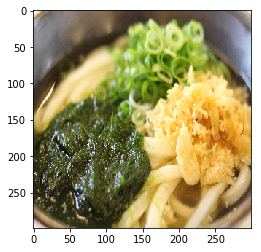

label=かやく pred_label=かけ


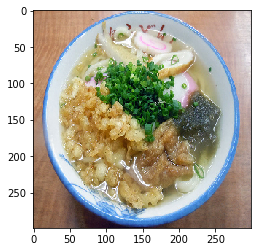

label=かけ pred_label=かけ


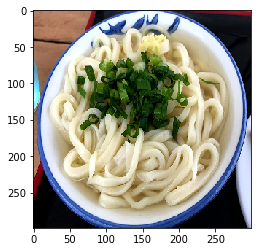

label=かけ pred_label=かやく


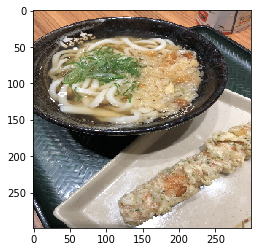

label=ぶっかけ pred_label=ぶっかけ


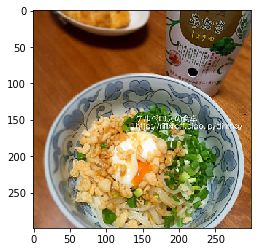

In [23]:
for i in range(5):
    pred_label = y_pred[i]
    idx = failed_idx[i]
    label = y_test[idx]
    img = X_test[idx]
    print("label=%s pred_label=%s" % (label_nm[label], label_nm[pred_label]))
    img = img.reshape(299,299,3)
    img = np.uint8(img*255)
    plt.imshow(img)
    plt.show()